# NOAA GEFS Basin Forecasts

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset and combines them into a single dataset with a unified structure.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Merge the individual basin forecasts into a combined dataset with dimensions: basin, time, lead_time, ensemble_member
5. Visualize and analyze the combined forecast data
6. Keep the dataset in memory for further processing

In [13]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Add src directory to path
sys.path.append('../src')
from fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    plot_ensemble_members,
    plot_ensemble_statistics,
    plot_quantile_distribution,
    plot_variables_comparison,
    plot_basin_forecasts
)

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [2]:
# Define paths for input and output data
basin_centroids_file = "../data/basin_centroids.csv"  # File containing basin centroid coordinates
output_dir = "../data/basin_forecasts"  # Directory for output data (for plots only)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")

Basin centroids file: ../data/basin_centroids.csv


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [3]:
# Load basin centroids
centroids = load_basin_centroids(basin_centroids_file)

# Display the basin coordinates
display(centroids)

Loaded 5 basin centroids from ../data/basin_centroids.csv


,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [4]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [5]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")
print("\nLatest 10 initialization times:")
for t in init_times[-10:]:
    print(f"  {t.strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1653
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1653
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-04-10 00:00

Latest 10 initialization times:
  2025-04-01 00:00
  2025-04-02 00:00
  2025-04-03 00:00
  2025-04-04 00:00
  2025-04-05 00:00
  2025-04-06 00:00
  2025-04-07 00:00
  2025-04-08 00:00
  2025-04-09 00:00
  2025-04-10 00:00

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensio

## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [6]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts)} basins")

Extracting forecasts for 5 basins...
Processing basin: innerste_reservoir_catchment_Basin_0 (lat: 51.8345, lon: 10.3078)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1653, 'ensemble_member': 31, 'lead_time': 181}

Extracted forecasts for 21 basins
Successfully extracted forecasts for 5 basins
Dataset dimen

In [7]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1653,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1653,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 410kB dask.array<chunksize=(1653, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1653, 181), meta=np.ndarray>
  * basin                                       (basin) <U36 720B 'innerste_r...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Visualize Forecast Data for a Specific Basin

Now let's create some visualizations for a specific basin to explore the forecast data.
We'll use the plotting functions from the source code which provide several types of plots:

1. Raw ensemble member plots - showing all ensemble members for a selected variable
2. Statistical distribution plots - showing the spread and uncertainty in the forecast
3. Ensemble quantile plots - showing the probabilistic distribution of the forecast
4. Comparative plots between different variables

In [8]:
# First, let's select a basin to visualize
# Get list of available basins
available_basins = basin_forecasts.basin.values
print(f"Available basins: {list(available_basins)}")

# Select the first basin for visualization (you can change this to any basin in the list)
selected_basin = available_basins[0]
print(f"\nSelected basin for visualization: {selected_basin}")

# Extract data for the selected basin
basin_data = basin_forecasts.sel(basin=selected_basin)

# Display basic information about this basin's forecast data
print(f"\nBasin data dimensions: {dict(basin_data.dims)}")
print(f"Available variables: {list(basin_data.data_vars)}")

Available basins: [np.str_('innerste_reservoir_catchment_Basin_0'), np.str_('oker_reservoir_catchment_Basin_0'), np.str_('ecker_reservoir_catchment_Basin_0'), np.str_('soese_reservoir_catchment_Basin_0'), np.str_('grane_reservoir_catchment_Basin_0')]

Selected basin for visualization: innerste_reservoir_catchment_Basin_0

Basin data dimensions: {'init_time': 1653, 'ensemble_member': 31, 'lead_time': 181}
Available variables: ['categorical_freezing_rain_surface', 'categorical_ice_pellets_surface', 'categorical_rain_surface', 'categorical_snow_surface', 'downward_long_wave_radiation_flux_surface', 'downward_short_wave_radiation_flux_surface', 'geopotential_height_cloud_ceiling', 'maximum_temperature_2m', 'minimum_temperature_2m', 'percent_frozen_precipitation_surface', 'precipitable_water_atmosphere', 'precipitation_surface', 'pressure_reduced_to_mean_sea_level', 'pressure_surface', 'relative_humidity_2m', 'temperature_2m', 'total_cloud_cover_atmosphere', 'wind_u_100m', 'wind_u_10m', 'wi

Using latest initialization time: 2025-04-10 00:00:00


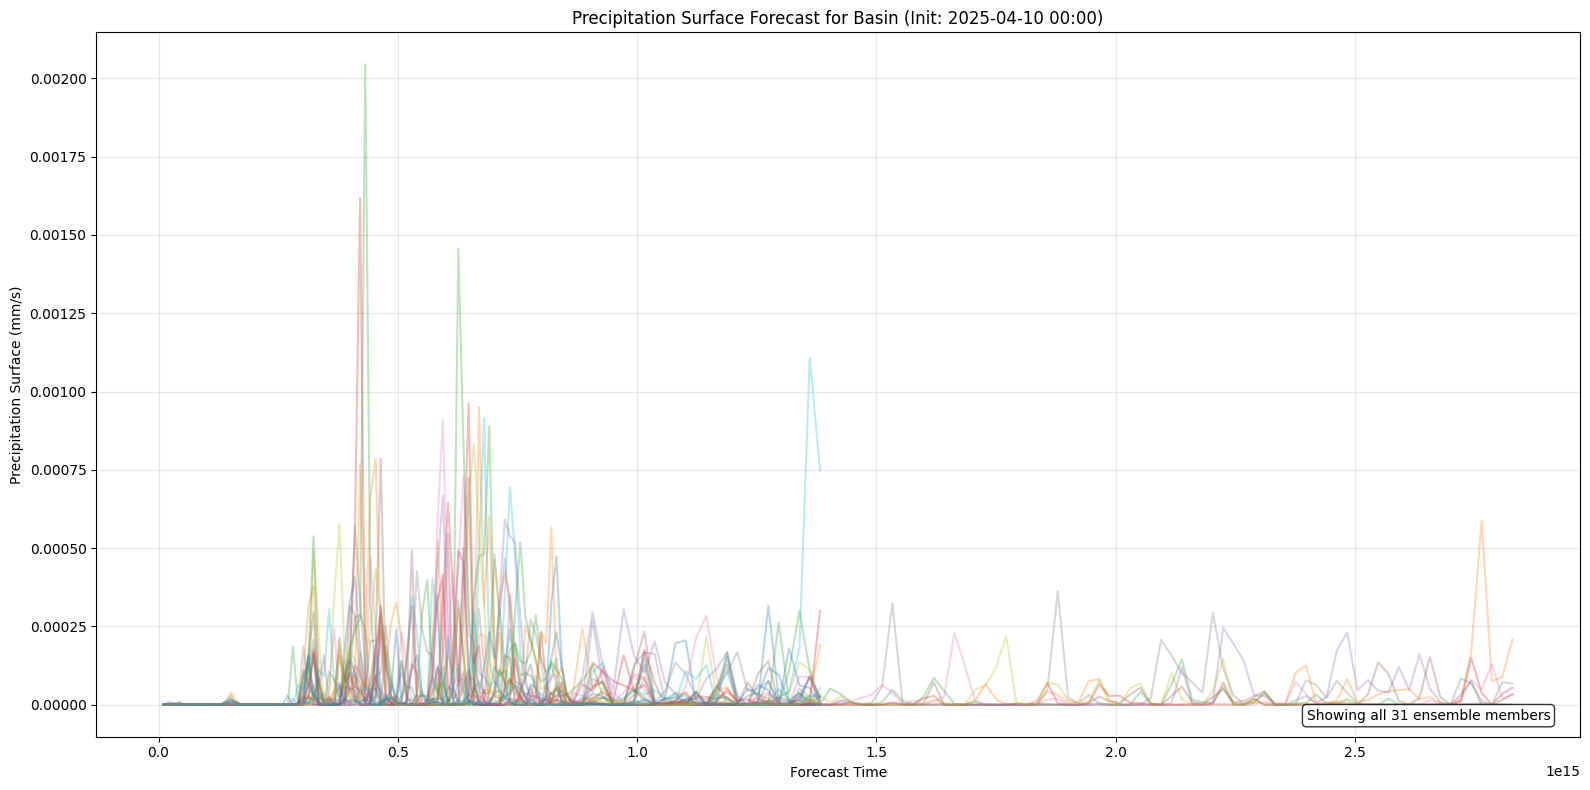

In [11]:
# Get the most recent initialization time for plotting
latest_init_time = basin_data.init_time.values[-1]
print(f"Using latest initialization time: {pd.to_datetime(latest_init_time)}")

# Plot all ensemble members for temperature
fig1 = plot_ensemble_members(basin_data, init_time=latest_init_time, variable='precipitation_surface')

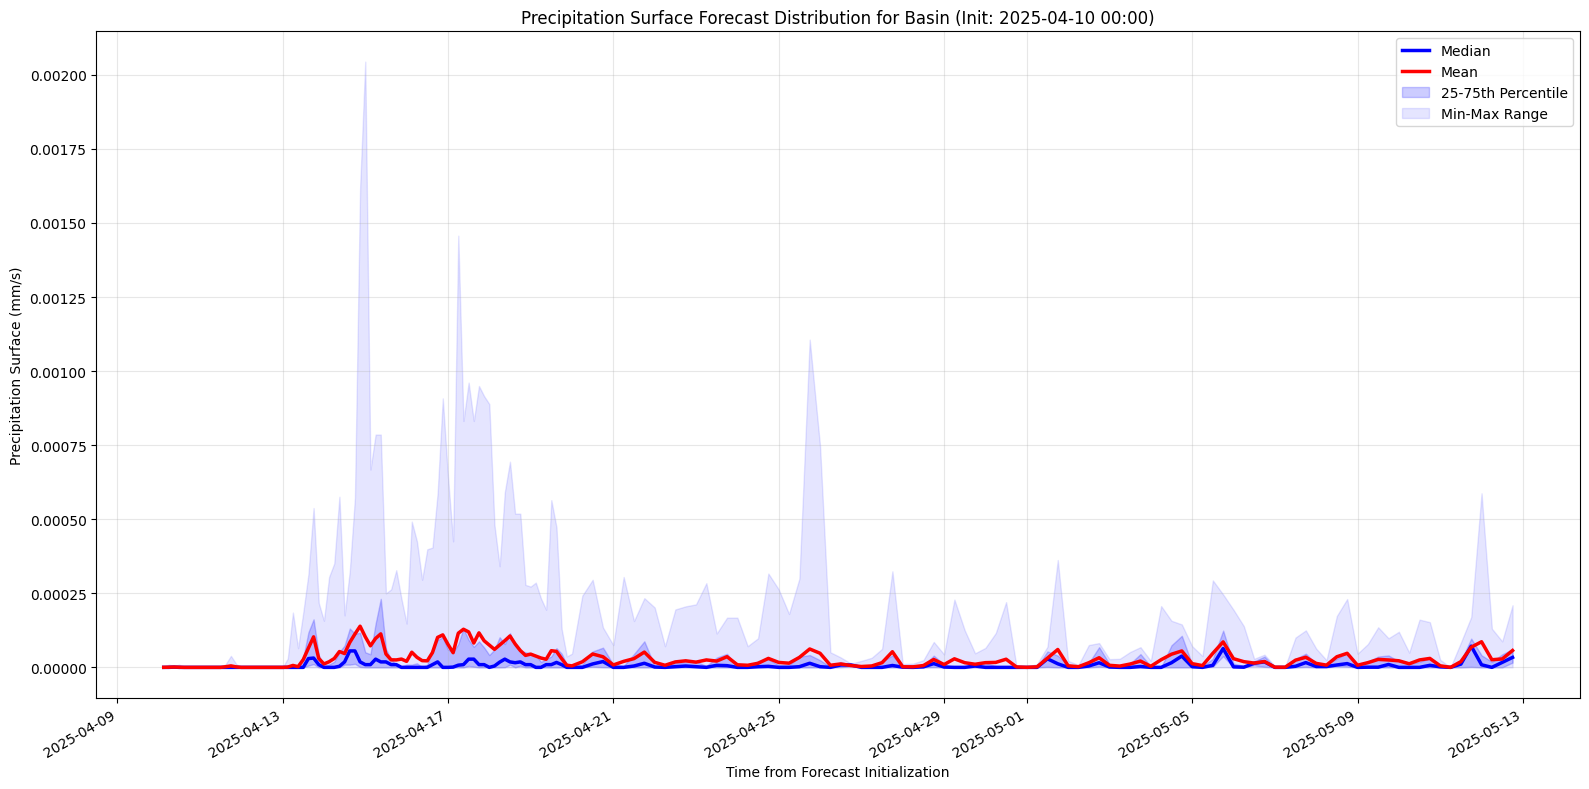

In [14]:
# Create a visualization showing the ensemble statistics (mean, median, range, percentiles)
fig2 = plot_ensemble_statistics(basin_data, init_time=latest_init_time, variable='precipitation_surface')

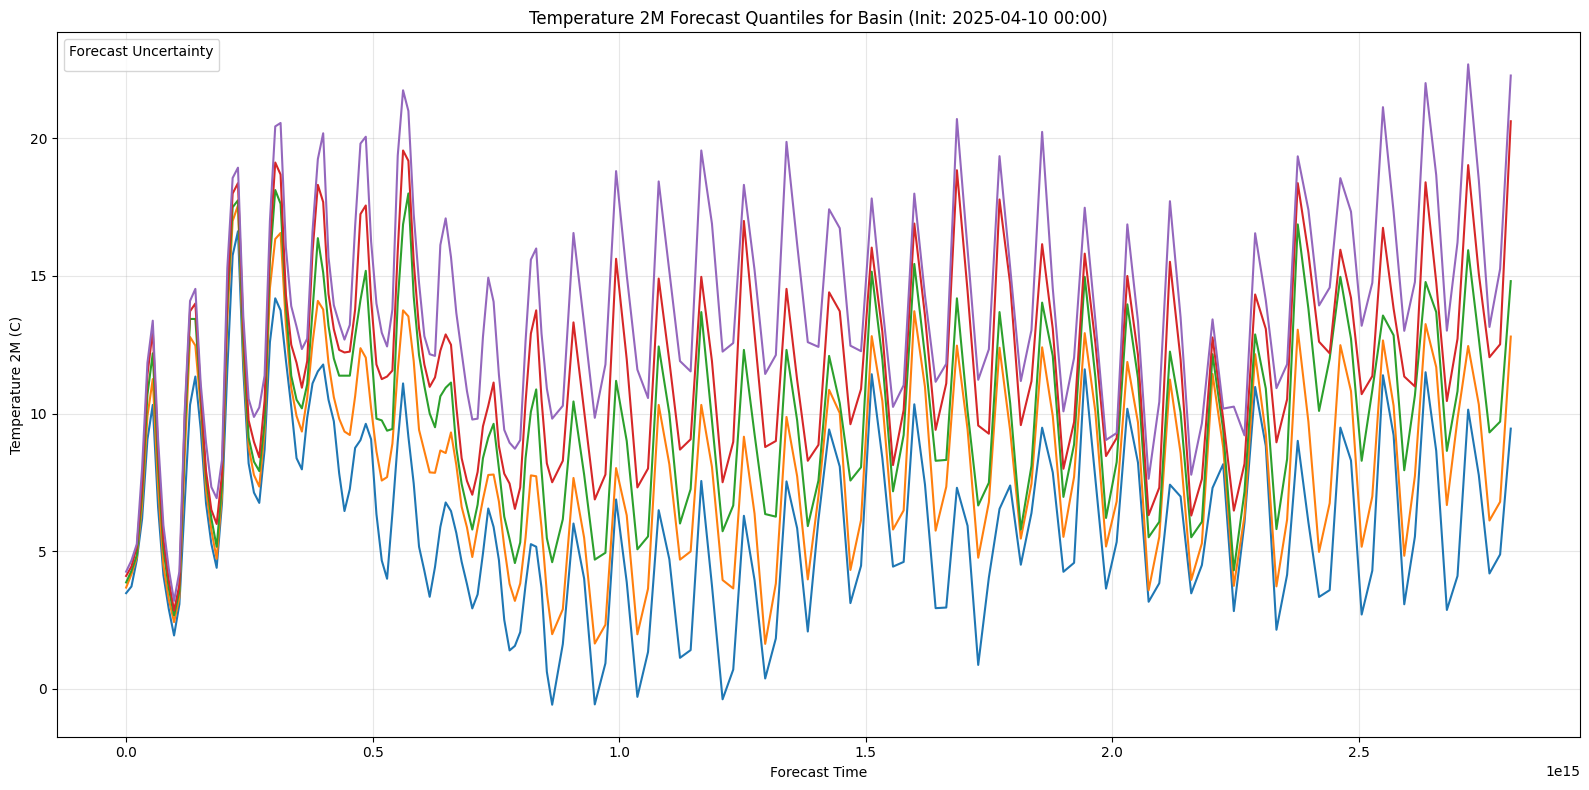

In [15]:
# Plot the ensemble quantile distribution
fig3 = plot_quantile_distribution(
    basin_data, 
    init_time=latest_init_time, 
    variable='temperature_2m',
    quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]
)

## Save the Combined Dataset

Now that we've analyzed the data, we can save the combined dataset to disk for future use.
This prevents the need to re-download and re-process the data each time.

In [ ]:
# # Save the dataset to disk with a timestamp to prevent overwriting previous forecasts
# timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# nc_filename = os.path.join(output_dir, f"basin_forecasts_{timestamp}.nc")

# print(f"Saving dataset to {nc_filename}...")
# try:
#     # Save as NetCDF file
#     basin_forecasts.to_netcdf(nc_filename)
#     print(f"Dataset saved successfully to {nc_filename}")
# except Exception as e:
#     print(f"Error saving dataset: {e}")
    
#     # Fallback: Try saving as a Zarr store if NetCDF fails
#     try:
#         zarr_filename = os.path.join(output_dir, f"basin_forecasts_{timestamp}.zarr")
#         print(f"Attempting to save as Zarr store to {zarr_filename}...")
#         basin_forecasts.to_zarr(zarr_filename)
#         print(f"Dataset saved successfully as Zarr store to {zarr_filename}")
#     except Exception as e2:
#         print(f"Error saving as Zarr store: {e2}")

## Conclusion

In this notebook, we have:

1. Loaded basin centroid coordinates from a CSV file
2. Connected to the NOAA GEFS 35-day forecast dataset
3. Extracted forecast data for each basin location
4. Created comprehensive visualizations of the forecast data using various plotting functions
5. Saved the combined dataset for future use

The plots generated provide insights into the forecast uncertainty and the variability across different initialization times and ensemble members. This information can be valuable for understanding potential weather patterns and their impacts on the basins.